In [1]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

In [2]:
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [3]:
data.train_mask.sum().item() # train_mask denotes against which nodes to train (140 nodes)
data.val_mask.sum().item() # val_mask denotes which nodes to use for validation, e.g., to perform early stopping (500 nodes)
data.test_mask.sum().item() # test_mask denotes against which nodes to test (1000 nodes).

1000

In [2]:
dct={}
for c in data.y[data.train_mask].numpy():
    if c in dct:
        dct[c] += 1
    else:
        dct[c] = 1
print(dct)

{3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20}


In [2]:
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim
import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

class GCN(nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, size_gcn, p_dropout):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()

        self.convs.append(GCNConv(num_features, hidden_channels))

        for i in range(size_gcn):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        
        # add dropout layer
        self.dropout = nn.Dropout(p=p_dropout)

        self.convs.append(GCNConv(hidden_channels, num_classes))

        self.act = F.leaky_relu

     # Model with leading dropout
    def forward(self, x, edge_index):
        for conv in self.convs:
            x = self.dropout(x)
            x = conv(x, edge_index)

            if conv != self.convs[-1]:
                x = self.act(x)

        return F.softmax(x, dim=1)

In [14]:
import optuna
from optuna.pruners import SuccessiveHalvingPruner, NopPruner
from torch.optim import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam
import numpy as np

n_trails = 100
n_jobs = 5 # Number of parallel jobs

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    hidden_channels = trial.suggest_categorical('hidden_channels', [16,32,64,128,256])
    size_gcn = trial.suggest_categorical('hidden_layers', [0,1,2])
    p_dropout = trial.suggest_float('p_dropout', 0.1, 0.7)
    #batch_size=trial.suggest_categorical('batch_size', [16,32,64,128,256])
    batch_size=trial.suggest_categorical('batch_size', [140]) # entire training set / batch training
    epochs = trial.suggest_categorical('epochs', np.arange(10,130,10).tolist())
    #optimizer = trial.suggest_categorical('optimizer', [SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam])
    optimizer = trial.suggest_categorical('optimizer', [Adam])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2)
    
    data = dataset[0]
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = GCN(num_features=data.num_features, num_classes=dataset.num_classes, hidden_channels=hidden_channels, size_gcn=size_gcn,p_dropout=p_dropout)
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9) #for RMSprop)

    for epoch in range(1, epochs+1):
        for data in loader:
            criterion=nn.CrossEntropyLoss()
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            #loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            trial.report(loss, epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Validate model
    model.eval()
    out = model(data.x, data.edge_index)  # Predicted probabilities
    probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
    pred = probas.argmax(dim=1)

    # Only consider validation data
    true_labels = data.y[data.val_mask].cpu().numpy()
    predicted_labels = pred[data.val_mask].cpu().numpy()

    # AUC for each class
    auc_list = []
    for i in range(probas.size(1)):
        try:
            auc_list.append(roc_auc_score((true_labels == i).astype(int), probas[data.val_mask, i].cpu().detach().numpy()))
        except ValueError:
            pass   
    avg_auc = sum(auc_list) / len(auc_list)

    # Recall
    recall = recall_score(true_labels, predicted_labels, average='macro')  # Using macro average

    # Acuracy
    correct = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
    acc = correct / data.val_mask.sum().item()
    print(f'Validation Accuracy: {acc * 100:.2f}%')
    
    # F1 score
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    #append the metrics to a csv file, and include the columns: avg_auc, recall, acc, f1
    with open('GCN_cora_test_results03.csv', 'a') as f:
        optimizer_name=optimizer.__class__.__name__
        f.write(f'{batch_size}, {hidden_channels},{size_gcn}, {lr}, {weight_decay}, {epochs}, {p_dropout}, {optimizer_name},{avg_auc},{recall},{acc},{f1}\n')
    
    return acc

study = optuna.create_study(direction="maximize", pruner=NopPruner())
#study = optuna.create_study(direction="minimize", pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=4, min_early_stopping_rate=0))
study.optimize(objective, n_trials=n_trails, timeout=600, n_jobs=n_jobs,show_progress_bar = True)
print(study.best_trial)

[I 2023-11-28 08:30:38,215] A new study created in memory with name: no-name-a270b158-5e02-4565-a724-abfb17ce05a0
C:\Users\ramme\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\ramme\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.
  warnings.warn(message)


[W 2023-11-28 08:30:38,282] Trial 1 failed with parameters: {'lr': 0.00030687860236541104, 'hidden_channels': 32, 'hidden_layers': 0, 'p_dropout': 0.670764603261524, 'batch_size': 140, 'epochs': 120, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weight_decay': 0.005139113627505945} because of the following error: TypeError("Adam.__init__() got an unexpected keyword argument 'momentum'").
Traceback (most recent call last):
  File "C:\Users\ramme\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ramme\AppData\Local\Temp\ipykernel_8972\2072571396.py", line 25, in objective
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9) #for RMSprop)
TypeError: Adam.__init__() got an unexpected keyword argument 'momentum'
[W 2023-11-28 08:30:38,282] Trial 4 failed with parameters: {'lr': 0.0006451579651256789, 'hidden_channels': 256, 'hidden_layers': 0, 'p_dropout': 0.20741906494

TypeError: Adam.__init__() got an unexpected keyword argument 'momentum'

In [14]:
# DELETE FILE that stores the HYPERPARAM'S
# import os
# if os.path.exists("GCN_cora_test_results03.csv"):
#     os.remove("GCN_cora_test_results03.csv")
#     print("The file was deleted")
# else:
#   print("The file does not exist")

The file was deleted


In [3]:
import pandas as pd
results_df = pd.read_csv('GCN_cora_test_results03.csv', header=None)
results_df.columns = ['batch_size', 'hidden_channels','size_gcn', 'lr', 'weight_decay', 'epochs', 'p_dropout', 'optimizer','avg_auc', 'recall', 'acc', 'f1']

results_df.sort_values('acc', ascending=False)
#results_df[results_df.optimizer.str.contains('RMSprop')].sort_values('acc', ascending=False).iloc[:5]

,batch_size,hidden_channels,size_gcn,lr,weight_decay,epochs,p_dropout,optimizer,avg_auc,recall,acc,f1
341,140,128,1,0.000105,0.000836,20,0.393128,RMSprop,0.959424,0.815745,0.812,0.795074
360,140,256,1,0.000038,0.000722,40,0.557796,RMSprop,0.958670,0.824032,0.810,0.800192
429,140,256,2,0.001465,0.001331,60,0.298345,Adam,0.950441,0.821225,0.810,0.796350
86,140,128,0,0.004761,0.001386,30,0.428875,Adamax,0.962403,0.819577,0.810,0.795934
482,140,32,1,0.001569,0.001502,80,0.315756,Adam,0.958259,0.824200,0.810,0.799259
...,...,...,...,...,...,...,...,...,...,...,...,...
103,140,32,0,0.000020,0.008980,70,0.187521,Adam,0.527525,0.165521,0.114,0.065352
405,140,64,2,0.000078,0.002736,20,0.580090,Adam,0.616998,0.145665,0.114,0.072436
442,140,64,2,0.000474,0.003884,60,0.388434,Adam,0.868431,0.172840,0.092,0.065905
317,140,128,1,0.006876,0.000044,100,0.110548,RMSprop,0.500000,0.142857,0.072,0.019190


In [20]:
# Get hyperparameters from dataframe
slc_row=0
batch_size=int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['batch_size'])
hidden_channels = int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['hidden_channels'])
#hidden_channels = 100 #apparently this has to be some big number?
size_gcn = int(results_df.sort_values('acc', ascending=False).iloc[slc_row]['size_gcn'])
lr = results_df.sort_values('acc', ascending=False).iloc[slc_row]['lr']
weight_decay = results_df.sort_values('acc', ascending=False).iloc[slc_row]['weight_decay']
epochs = results_df.sort_values('acc', ascending=False).iloc[slc_row]['epochs']
p_dropout = results_df.sort_values('acc', ascending=False).iloc[slc_row]['p_dropout']

In [28]:
# Get hyperparameters from dataframe - select specific OPTIMIZER
from torch.optim import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam
slc_row=0
optim='Adam'
batch_size=int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['batch_size'])
hidden_channels = int(results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['hidden_channels'])
size_gcn = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['size_gcn']
lr = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['lr']
weight_decay = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['weight_decay']
epochs = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['epochs']
p_dropout = results_df[results_df.optimizer.str.contains(optim)].sort_values('acc', ascending=False).iloc[slc_row]['p_dropout']

In [8]:
def train(model,optimizer,data,epoch):
    criterion=nn.CrossEntropyLoss()
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    #print(f'Epoch: {epoch}, Loss: {loss.item()}')

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)  # Predicted probabilities
    # print(out.size()) # torch.Size([2708, 7])
    probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
    pred = probas.argmax(dim=1)

    # Test data
    true_labels = data.y[data.test_mask].cpu().numpy()
    predicted_labels = pred[data.test_mask].cpu().numpy()

    # AUC for each class
    auc_list = []
    for i in range(probas.size(1)):
        try:
            auc_list.append(roc_auc_score((true_labels == i).astype(int), probas[data.test_mask, i].cpu().detach().numpy()))
        except ValueError:
            pass   
    avg_auc = sum(auc_list) / len(auc_list)

    # Recall
    recall = recall_score(true_labels, predicted_labels, average='macro')  # Using macro average
    #print(f'Test Recall: {recall:.4f}')

    # Acuracy
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    #print(f'Test Accuracy: {acc * 100:.2f}%')

    # F1 score
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    #print(f'Test F1 score: {f1:.4f}')

    #append the metrics to a csv file, and include the columns: avg_auc, recall, acc, f1
    with open('GCN_cora_best_model_metrics03.csv', 'a') as f:
        f.write(f'{avg_auc},{recall},{acc},{f1}\n')

def test_GCN(dataset,batch_size,hidden_channels,size_gcn,p_dropout,lr,weight_decay,epochs,optimizer):

    data = dataset[0]
    loader = DataLoader(dataset, batch_size, shuffle=True)
    # Initialize the model and optimizer
    model = GCN(num_features=data.num_features, num_classes=dataset.num_classes, hidden_channels=hidden_channels, size_gcn=size_gcn,
                p_dropout=p_dropout)
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)#,momentum=0.9)
    # Training loop
    for epoch in range(1, epochs+1):
        for data in loader:
            train(model,optimizer,data,epoch)
    
    test(model,data)

In [29]:
# DELETE FILE that stores the METRICS
import os
if os.path.exists("GCN_cora_best_model_metrics03.csv"):
    os.remove("GCN_cora_best_model_metrics03.csv")
    print("The file was deleted")
else:
  print("The file does not exist")

The file was deleted


In [30]:
import time
times=[]
optimizer=Adam
momentum = 0.9
for i in range (0,10):
    st = time.time()
    test_GCN(dataset,batch_size,hidden_channels,size_gcn,p_dropout,lr,weight_decay,epochs,optimizer)
    et = time.time()
    elapsed_time = et - st
    #print('Execution time:', elapsed_time, 'seconds')
    times.append(elapsed_time)

In [31]:
best_model_df = pd.read_csv('GCN_cora_best_model_metrics03.csv', header=None)
best_model_df.columns = ['avg_auc', 'recall', 'acc', 'f1']
best_model_df['train_and_test_time']=times
avg_df=best_model_df[['avg_auc', 'recall', 'acc', 'f1','train_and_test_time']].mean()

In [32]:
avg_df

avg_auc                0.954762
recall                 0.811673
acc                    0.791500
f1                     0.789068
train_and_test_time    6.235918
dtype: float64

In [27]:
best_model_df['acc'].std()

0.002223610677354391

In [21]:
from torch.optim import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, NAdam

gcn = GCN(data.num_features, dataset.num_classes, hidden_channels,size_gcn,p_dropout)

optimizer=RMSprop

data = dataset[0]
loader = DataLoader(dataset, batch_size, shuffle=True)
# Initialize the model and optimizer
optimizer = optimizer(gcn.parameters(), lr=lr, weight_decay=weight_decay,momentum=0.9) #for RMSprop)
# Training loop

for epoch in range(1, epochs+1):
    for data in loader:
        train(gcn,optimizer,data,epoch)

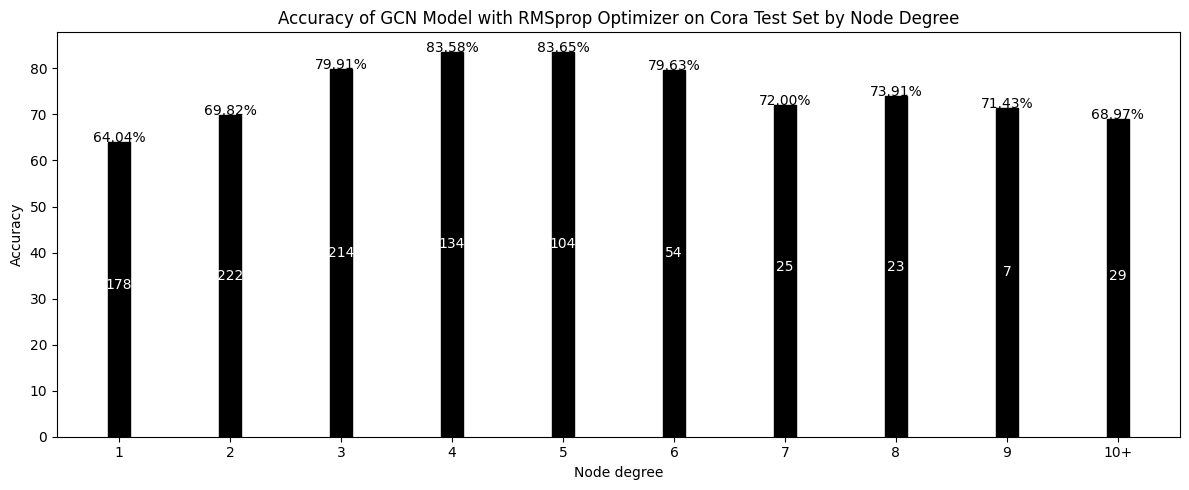

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return (sum(y_pred == y_true) / len(y_true))*100

# Get model's classifications
out = gcn(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()
# Select degrees of nodes in test set
degrees=degrees[data.test_mask.numpy()]

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

probas = torch.nn.functional.softmax(out, dim=1)  # Convert logits to probabilities
pred = probas.argmax(dim=1)

# Test data
true_labels = data.y[data.test_mask].cpu().numpy()
predicted_labels = pred[data.test_mask].cpu().numpy()

# Accuracy for degrees between 0 and 5
for i in range(1, 10):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(predicted_labels[mask], true_labels[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 10
mask = np.where(degrees > 10)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(12,5))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy')
plt.bar(['1','2','3','4','5','6','7','8','9','10+'], accuracies, width=0.2, color='black', edgecolor='black')
for i in range(0, 10):
    plt.text(i, accuracies[i], f'{accuracies[i]:.2f}%', ha='center', color='black')
for i in range(0, 10):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

plt.title('Accuracy of GCN Model with RMSprop Optimizer on Cora Test Set by Node Degree')
plt.tight_layout()
plt.savefig('GCN_Cora_RMSprop_Accuracy_by_Degree.png')

plt.show()